# Tienda Online de sandias (Test A / B)

## Descripción del proyecto

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

### Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

## Diccionario de datos 

1. ab_project_marketing_events_us.csv: el calendario de eventos de marketing para 2020
- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

2. final_ab_new_users_upd_us.csv: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

3. final_ab_events_upd_us.csv: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

4. final_ab_participants_upd_us.csv: tabla con los datos de los participantes de la prueba
- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

## Librerias 

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import math as mth 
import numpy as np
import pandas as pd 
import seaborn as sns
import scipy.stats as stats 

## Cargar datos 

In [2]:
# funcion para cargar datos con la libreria pandas
def cargar_datos(file_name):
    data = pd.read_csv(file_name)
    return data

In [3]:
# calendario eventos marketing
marketing = cargar_datos('/datasets/ab_project_marketing_events_us.csv')

# usuarios registrados del 7 al 21 de diciembre 2020
users = cargar_datos('/datasets/final_ab_new_users_upd_us.csv')

# eventos de los nuevos usuarios del 7 de diciembre 2020 al 1 de enero 2021
events = cargar_datos('/datasets/final_ab_events_upd_us.csv')

# participantes de la prueba
participants = cargar_datos('/datasets/final_ab_participants_upd_us.csv')

## Pre procesamiento de datos 

In [4]:
# funcion para obtener un panorama general del dataset
def leer_datos(df):
    print(df.head(5))
    df.info()
    print(df.describe())


In [5]:
# funcion para identificar valores duplicados y ausentes
def valores_datos(df):
    duplicados = df.duplicated().sum()
    print(f'Valores duplicados: {duplicados}\n')
    ausentes = df.isna().sum()
    print(f'Valores ausentes:\n{ausentes}')

### dataset Calendario de eventos de Marketing

In [6]:
leer_datos(marketing)

                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
                                   name regions    start_dt   finish_dt
count       

In [7]:
# convertir los tipos de datos de start_dt y finish_dt
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])

In [8]:
valores_datos(marketing)

Valores duplicados: 0

Valores ausentes:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64


<span style="color:purple; font-weight:bold; font-size: 18px">
En este primer data set no se encontraron valores ausentes ni duplicados. Solo se realizaron cambios en las columnas que contienen fechas ya que era un object, y se transformo a datetime
</span>

### Dataset usuarios del 7 de diciembre al 21 de diciembre 

In [9]:
leer_datos(users)

            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
                 user_id  first_date region   device
count              58703       58703  58703    58703
unique             58703          17      4        4
top     738C5F219CA0CCC4  2020-12-21     EU  Android
freq                   1        6077  43396    26159


In [10]:
# cambiar el tipo de datos de la columna first_date
users['first_date'] = pd.to_datetime(users['first_date'])

In [11]:
valores_datos(users)

Valores duplicados: 0

Valores ausentes:
user_id       0
first_date    0
region        0
device        0
dtype: int64


<span style="color:purple; font-weight:bold; font-size: 18px">
En este dataset no se encontraron valores duplicados ni ausentes, de la misma forma que en el anterior DF se cambio el tipo de datos de object a Datetime.
</span>

### Dataset Eventos de nuevos usuarios del 7 de Diciembre de 2020 al 1 de Enero de 2021

In [12]:
leer_datos(events)

            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
            details
count  60314.000000
mean      23.881219
std       72.228884
min        4.990000
25%        4.990000
50%        4.990000
75%        9.990000
max      499.990000


In [13]:
# convertir el tipo de dato de la columna event_dt
events['event_dt'] = pd.to_datetime(events['event_dt'])

In [14]:
valores_datos(events)

Valores duplicados: 0

Valores ausentes:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64


<span style="color:purple; font-weight:bold; font-size: 18px">
En este dataset si se encontraron 363,447 valores ausentes en la columna de 'details', sin embargo por el momento no se eliminaran ni se rellenaran con algun otro dato ya que estos son importantes para analizar los valores outliers, dentro del experimento. Por ultimo se cambio el tipo de datos de la columna 'event_dt' de object a datetime.
</span>

### Participantes de la prueba 

In [15]:
leer_datos(participants)

            user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  4FF2998A348C484F     A  recommender_system_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     F1B93BAE75EE0FB2      A  interface_eu_test
freq                   2   8214              10850


In [16]:
valores_datos(participants)

Valores duplicados: 0

Valores ausentes:
user_id    0
group      0
ab_test    0
dtype: int64


<span style="color:purple; font-weight:bold; font-size: 18px">
En este ultimo DF no se encontraron valores ausentes ni duplicados.
</span>

## Análisis exploratorio de datos (EDA)

### Estudia la conversión en las diferentes etapas del embudo.

#### Embudo del total de usuarios

In [17]:
# numero de usuarios por eventos
eventos_por_tipo = events.groupby('event_name')['user_id'].count().reset_index()

In [18]:
# renombrar columnas 
eventos_por_tipo.columns = ['Stage', 'Quantity']

In [19]:
# ordenar datos por cantidad
eventos_por_tipo.sort_values(by='Quantity', ascending=False, inplace=True)

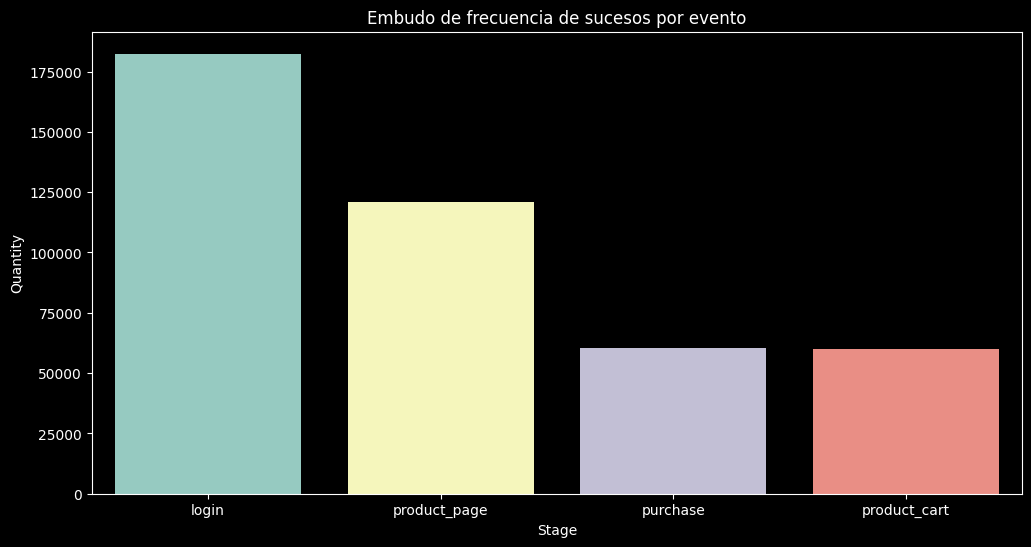

In [20]:
# mostrar embudo
with plt.style.context('dark_background'):
    plt.figure(figsize=(12,6))
    sns.barplot(
        x='Stage',
        y='Quantity',
        data = eventos_por_tipo
    )

    plt.title('Embudo de frecuencia de sucesos por evento')
    plt.show()

#### Calculo de conversión de usuarios

In [21]:
# total de usuarios (
users_total = events['user_id'].count()
print(f'El total de usuarios es: {users_total}')

El total de usuarios es: 423761


In [22]:
# extraer los usuarios unicos de cada evento
users_uniq = events.groupby('event_name').agg({'user_id' : 'nunique'})

# ordenar los valores por user_id de forma descente
users_uniq.sort_values(by='user_id', ascending = False, inplace = True)

print(users_uniq)

              user_id
event_name           
login           58696
product_page    38929
purchase        19568
product_cart    19284


In [23]:
# calcular la proporcion de usuarios de la tasa de conversion
conversion =  (users_uniq / users_total) * 100 
# imprimir la convercion
print(conversion.round(2))

              user_id
event_name           
login           13.85
product_page     9.19
purchase         4.62
product_cart     4.55


<span style="color:purple; font-weight:bold; font-size: 18px">
En este primer embudo se calculo la tasa de conversion y se obtuvo como resultado que solo 13 % de los usuarios/as se logean en el sitio, un 9.19% visitan la pagina de productos, un 4.62% realiza una compra y un 4.55% va a la pagina de carrito. Mas adelante se comprobara si existe algun cambio con el experimento
</span>

#### Usuarios/as que pasan de etapa (segun lo esperado)

In [24]:
# calcular la proporcion de usuarios/as que pasan a una etapa siguiente
stage_pivot = events.pivot_table(
    index='user_id',
    columns='event_name',
    values='event_dt', 
    aggfunc='min'
)

In [25]:
stage_pivot

event_name,login,product_cart,product_page,purchase
user_id,,,,
0001710F4DDB1D1B,2020-12-14 20:20:40,2020-12-14 20:20:42,2020-12-14 20:20:41,NaT
000199F1887AE5E6,2020-12-14 09:56:09,2020-12-14 09:56:11,2020-12-14 09:56:09,2020-12-14 09:56:09
0002499E372175C7,2020-12-22 03:49:52,NaT,2020-12-22 03:49:55,2020-12-22 03:49:52
0002CE61FF2C4011,2020-12-07 04:37:36,2020-12-07 04:37:37,2020-12-07 04:37:42,NaT
000456437D0EFFE1,2020-12-15 11:25:03,NaT,2020-12-15 11:25:04,NaT
...,...,...,...,...
FFF7A7BAF44FE9B4,2020-12-19 11:10:03,NaT,NaT,NaT
FFF8FDBE2FE99C91,2020-12-20 04:53:50,NaT,2020-12-20 04:53:51,2020-12-20 04:53:50
FFF91B6C5431F375,2020-12-14 22:12:04,2020-12-14 22:12:04,NaT,NaT


In [26]:
# declarar los pasos esperados que los usuarios hicieron en los eventos 
step_1 = ~stage_pivot['login'].isna()
step_2 = step_1 & (stage_pivot['product_page'] > stage_pivot['login'])
step_3 = step_2 & (stage_pivot['product_cart'] > stage_pivot['product_page'])
step_4 = step_3 & (stage_pivot['purchase'] > stage_pivot['product_cart'])

In [27]:
# crear variables con los pasos de la hora de su primer visita y los que realizaron la accion
n_login = stage_pivot[step_1].shape[0]
n_product_page = stage_pivot[step_2].shape[0]
n_product_cart = stage_pivot[step_3].shape[0]
n_purchase = stage_pivot[step_4].shape[0]


In [28]:
print('Se loggeo en la pagina:', n_login)
print('Entro a la pagina del producto:', n_product_page)
print('Agrego productos al carrito:', n_product_cart)
print('Realizo la compra:', n_purchase)

Se loggeo en la pagina: 58696
Entro a la pagina del producto: 22119
Agrego productos al carrito: 1347
Realizo la compra: 6


<span style="color:purple; font-weight:bold; font-size: 18px">
Se analizo el embudo esperado que los clientes deberian realizar y se encontro que solo 6 personas realizan una compra en el sitio.
</span>

#### Perdida de usuarios en cada etapa 

In [29]:
# crear diccionario con los datos obtenidos
embudo_nuevo_usuarios = {
    'login' : n_login,
    'product_page' : n_product_page,
    'product_cart' : n_product_cart,
    'purchase' : n_purchase
}

In [30]:
# crear df con los datos del embudo 
df_embudo = pd.DataFrame(list(embudo_nuevo_usuarios.items()))

# renombrar columnas 
df_embudo.columns = ['event_name', 'usuarios_despues_embudo']

In [31]:
df_embudo

,event_name,usuarios_despues_embudo
0,login,58696
1,product_page,22119
2,product_cart,1347
3,purchase,6


In [32]:
# comparar los usuarios unicos iniciales con los que resultaron del nuevo embudo 
user_unicos = users_uniq.sort_values(by='user_id', ascending=False).reset_index()

# renombrar columnas 
user_unicos.columns = ['event_name', 'usuarios_iniciales']

In [33]:
# combinar los DF 
embudos_comparados = user_unicos.merge(df_embudo, on='event_name')

In [34]:
# ordenar de manera descendente
embudos_comparados.sort_values(by='usuarios_despues_embudo', ascending=False, inplace=True)

In [35]:
# calcular la diferencia entre los usuarios iniciales y los que sobraron despues de la ruta esperada 
embudos_comparados['usuarios_perdidos'] = embudos_comparados['usuarios_iniciales'] - embudos_comparados['usuarios_despues_embudo']

# mostrar resultado
embudos_comparados

,event_name,usuarios_iniciales,usuarios_despues_embudo,usuarios_perdidos
0,login,58696,58696,0
1,product_page,38929,22119,16810
3,product_cart,19284,1347,17937
2,purchase,19568,6,19562


<span style="color:purple; font-weight:bold; font-size: 18px">
Despues se calcularon cuantos usuarios se pierden en cada una de las etapas del embudo, lo que dio como resultado, que la etapa donde se pierden mas usuarios/as es de product_cart a purchase teniendo una enorme cantidad de 19,562 usuarios perdidos, mientras que de product_page a product_cart se pierde un total de 17,937 usuarios/as finalmente en la etapa de product_page se pierden 16,810 usuarios/as mas lo que se perdieron de la pagina de login. 
</span>

In [36]:
# calcular porcentaje de usuarios perdidos en cada etapa 
embudos_comparados['conversion_siguiente_etapa'] = (
    embudos_comparados['usuarios_despues_embudo'] / embudos_comparados['usuarios_iniciales']) * 100

In [37]:
# redondear el resultado 
embudos_comparados['conversion_siguiente_etapa'] = embudos_comparados['conversion_siguiente_etapa'].round(2)

In [38]:
embudos_comparados

,event_name,usuarios_iniciales,usuarios_despues_embudo,usuarios_perdidos,conversion_siguiente_etapa
0,login,58696,58696,0,100.00
1,product_page,38929,22119,16810,56.82
3,product_cart,19284,1347,17937,6.99
2,purchase,19568,6,19562,0.03


<span style="color:purple; font-weight:bold; font-size: 18px">
En terminos de porcentaje solo un 56.82% de los usuarios realizan la accion de visitar product_page, solo 6.99% entran a product_cart y solo 0.03% de los usuarios iniciales completan la compra. 
</span>

### ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [39]:
# contar el numero de participantes por grupo
group_size = participants.groupby('group')['user_id'].count().reset_index(name='count_users')

In [40]:
# calcular el total de usuarios de ambos grupos
total_users = group_size['count_users'].sum()
# calcular la proporcion 
group_size['proportion'] = group_size['count_users'] / total_users

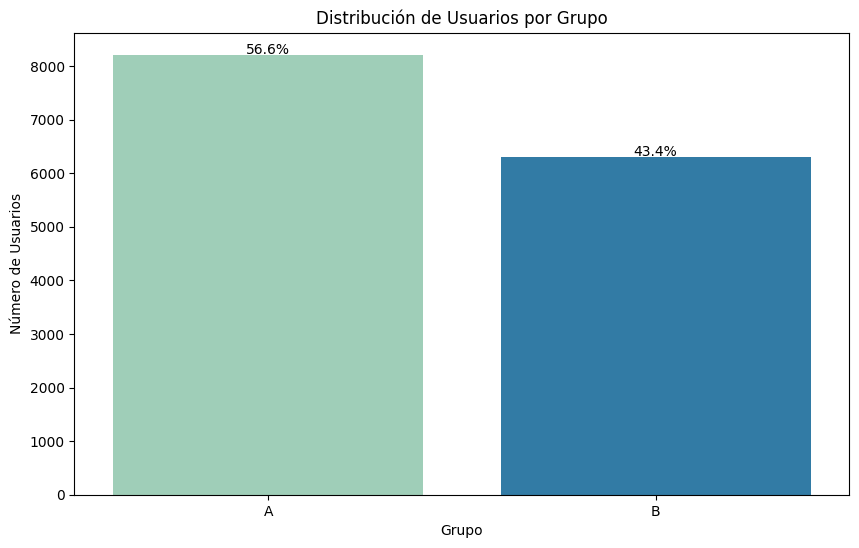

In [41]:
# mostrar grafico de barras con las proporciones de ambas muestras
plt.figure(figsize=(10,6))
sns.barplot(data=group_size, x='group', y='count_users', palette='YlGnBu')

plt.title('Distribución de Usuarios por Grupo')
plt.xlabel('Grupo')
plt.ylabel('Número de Usuarios')

# mostrar el porcentaje que cada muestra representa
for i, row in group_size.iterrows():
    plt.text(i, row['count_users'] + 10, f"{row['proportion']:.1%}", ha='center', fontsize=10)

plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
En cuanto a la distribucion de las muestras se observa que el grupo A cuenta con un 56.6% del total de participantes, mientras que el grupo B tiene 43.4% lo que significa una diferencia del 13.2% entre grupos, lo que sugiere que el grupo A cuenta con mas representacion, lo que podria influir en los resultados
</span>

### ¿Hay usuarios que están presentes en ambas muestras?

In [42]:
# filtro de usuarios unicos por grupo
users_a = participants[participants['group'] == 'A']['user_id'].unique()
users_b = participants[participants['group'] == 'B']['user_id'].unique()

In [43]:
# buscar si aparecen en ambas pruebas con la funcion intersection
users_duplicated = set(users_a).intersection(set(users_b))

print(f'Numero de usuarios en ambas muestras: {len(users_duplicated)}')

Numero de usuarios en ambas muestras: 441


<span style="color:purple; font-weight:bold; font-size: 18px">
Por otra parte se encontro otra pecularidad en los datos ya que se encontraron un total de 441 usuarios en ambas muestras.
</span>

### ¿Cómo se distribuye el número de eventos entre los días?

In [44]:
# crear columna con fecha sin hora
events['date'] = events['event_dt'].dt.date

In [45]:
# filtrar datos entre las fechas de inicio y final 
fecha_inicio = events['date'].min()
fecha_final = events['date'].max()

filtro_fecha = (events['date'] >= fecha_inicio) & (events['date'] <= fecha_final)
datos_filtrados = events[filtro_fecha]

In [46]:
# contar eventos por dia
eventos_por_dia = datos_filtrados.groupby('date')['event_name'].count()
eventos_por_dia

date
2020-12-07    11385
2020-12-08    12547
2020-12-09    12122
2020-12-10    14077
2020-12-11    13864
2020-12-12    17634
2020-12-13    20985
2020-12-14    26184
2020-12-15    23469
2020-12-16    20909
2020-12-17    21751
2020-12-18    22871
2020-12-19    24273
2020-12-20    26425
2020-12-21    32559
2020-12-22    29472
2020-12-23    26108
2020-12-24    19399
2020-12-26    14058
2020-12-27    12420
2020-12-28    11014
2020-12-29    10146
2020-12-30       89
Name: event_name, dtype: int64

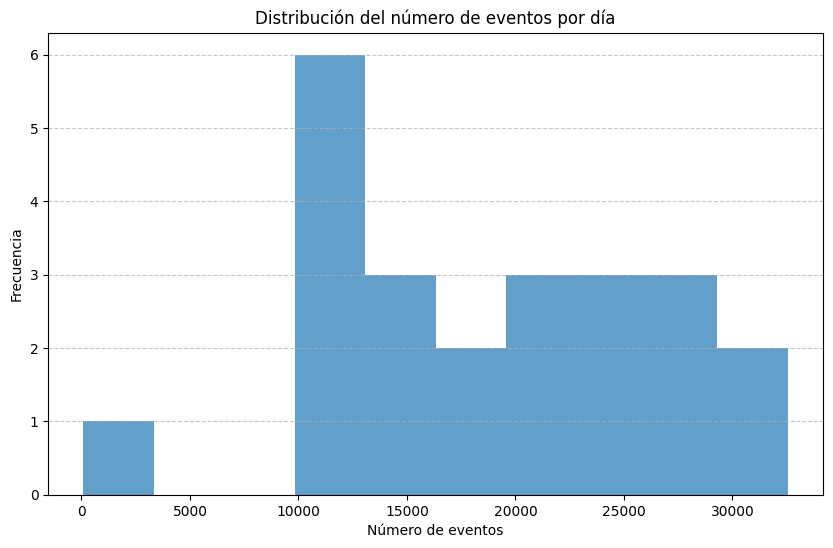

In [47]:
# histograma con distribuciones de eventos por dia 
plt.figure(figsize=(10,6))
plt.hist(eventos_por_dia, bins=10, alpha=0.7)
plt.title('Distribución del número de eventos por día')
plt.xlabel('Número de eventos')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

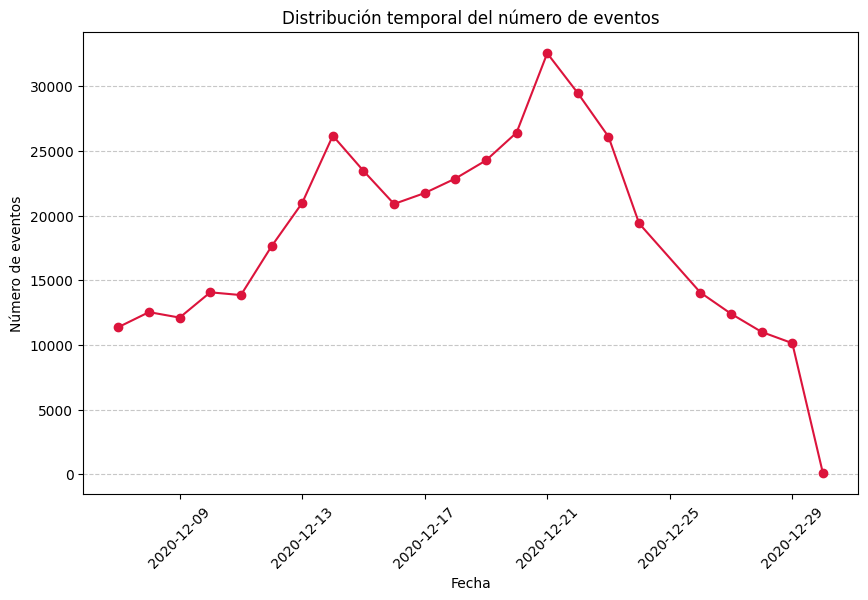

In [48]:
# grafico de lineas 
eventos_por_dia.plot(
    title='Distribución temporal del número de eventos',
    xlabel='Fecha', 
    ylabel='Número de eventos', 
    figsize=(10,6), 
    marker='o',
    color='crimson'
)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<span style="color:purple; font-weight:bold; font-size: 18px">
Al analizar los eventos por dias se logra visualizar que la mayoria supera los 10,000 eventos, sin embargo en el ultimo dia del año hay una baja considerable de eventos, pasando de los 10,146 de un dia anterior a 89 eventos. 
</span>

### ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

#### Revisar valores atípicos de la cantidad de eventos por usuario/a

In [49]:
# calcular la cantidad de eventos por usuario
user_events_total = events.groupby('user_id')['event_name'].count().reset_index(name='total_eventos')

# ordenar los datos
user_events_total.sort_values(by='total_eventos', ascending=False)

,user_id,total_eventos
37526,A3917F81482141F2,36
7403,203773F2A53233A8,32
3965,11285A53EC2B2042,32
42807,BA87FD8D70D63CC6,32
12472,365C8B51237C61AF,32
...,...,...
27886,7A2073BD661AF70D,1
15918,452225689815A700,1
45177,C5293D68FDC0D086,1
52381,E48564406C361C95,1


<span style="color:purple; font-weight:bold; font-size: 18px">
Otra peculiaridad en los datos es que hay usuarios que hacen mas de un evento.
</span>

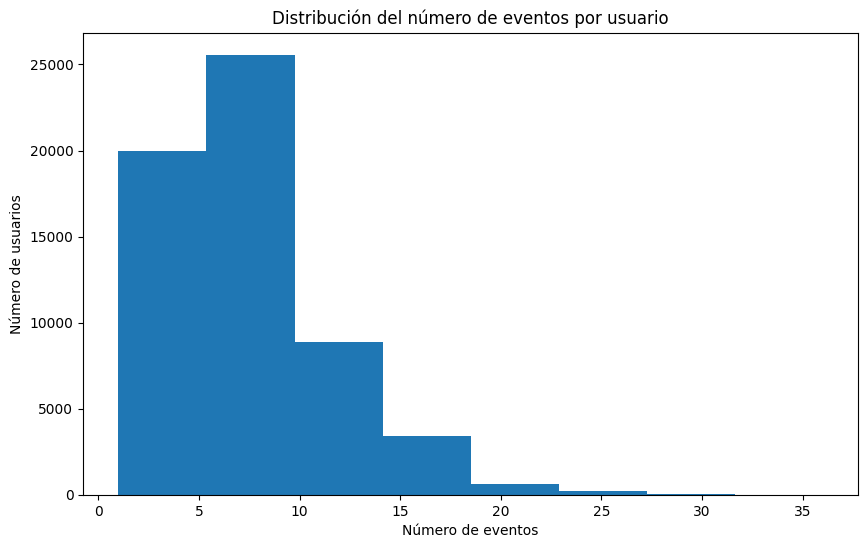

In [50]:
# distribucion de los datos
plt.figure(figsize=(10,6))
plt.hist(user_events_total['total_eventos'], bins=8)

plt.title('Distribución del número de eventos por usuario')
plt.xlabel('Número de eventos')
plt.ylabel('Número de usuarios')
plt.show()

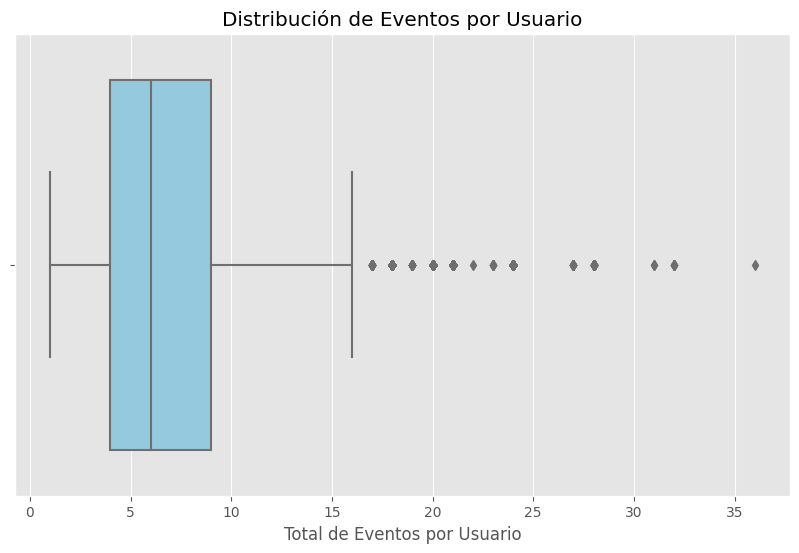

In [51]:
# crear boxplot para observar valores atipicos

with plt.style.context('ggplot'):

    # Crear el boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=user_events_total, x='total_eventos', color='skyblue')

    plt.title('Distribución de Eventos por Usuario')
    plt.xlabel('Total de Eventos por Usuario')
    
    plt.show()

In [52]:
# medidas de dispersion 
print('La media es:', user_events_total['total_eventos'].mean())
print('La mediana es:', user_events_total['total_eventos'].median())
print('La moda es:', user_events_total['total_eventos'].mode())

La media es: 7.218728174028585
La mediana es: 6.0
La moda es: 0    6
dtype: int64


In [53]:
print(np.percentile(user_events_total['total_eventos'], [90,95,99,100]))

[12. 15. 20. 36.]


<span style="color:purple; font-weight:bold; font-size: 18px">
Al observar los graficos donde se muestra la distribución de los datos, se aprecia que existen muchos valores atípicos, ya que la media del total de eventos es de 7.2, y al calcular los percentiles, se obtuvo que  el 10% de los usuarios realiza 12 eventos, el 5% realiza 15 eventos, y solo el 1% realiza 20 eventos y 36 es numero maximo de eventos por usuario.
</span>

#### Revisar valores atípicos de compras hechas por usuarios/as

In [54]:
# obtener el total de las compras hechas por usuario
user_buy = events.groupby('user_id')['details'].sum().reset_index(name='total_compras')

# ordenar los datos de manera descendente por cantidad de compra
user_buy.sort_values(by='total_compras', ascending=False)

,user_id,total_compras
36307,9E4A562DC7FE3F82,1609.94
35750,9BBC25973E2B9763,1124.93
40161,AEEAC27AD37EFE7A,1114.95
43609,BE2A590658875C91,1109.95
9892,2B11361D0BDB293A,1109.95
...,...,...
23558,66E02518441F5E9C,0.00
23559,66E0CBF90827B836,0.00
23562,66E3E57ACE5022F7,0.00
23563,66E403BA8A7B48E5,0.00


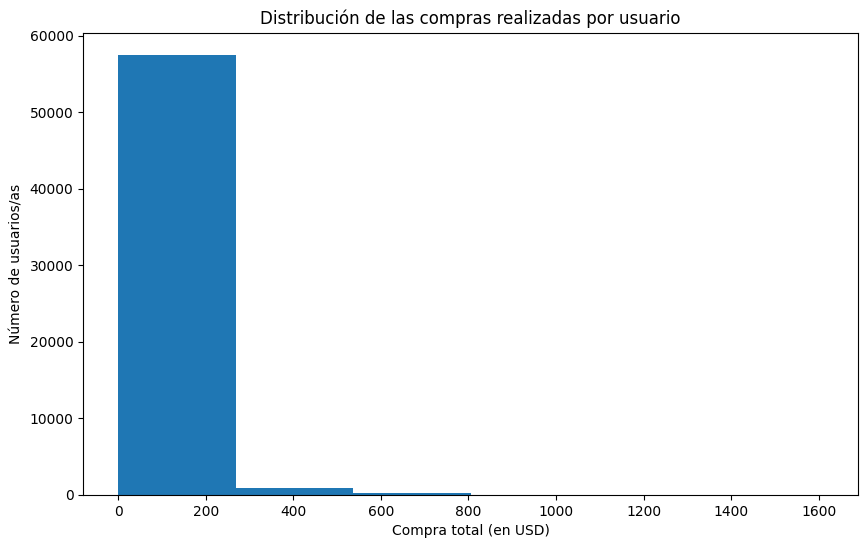

In [55]:
# trazar histograma para conocer la distribucion de las compras
plt.figure(figsize=(10,6))
plt.hist(user_buy['total_compras'], bins=6)

plt.title('Distribución de las compras realizadas por usuario')
plt.xlabel('Compra total (en USD)')
plt.ylabel('Número de usuarios/as')

plt.show()

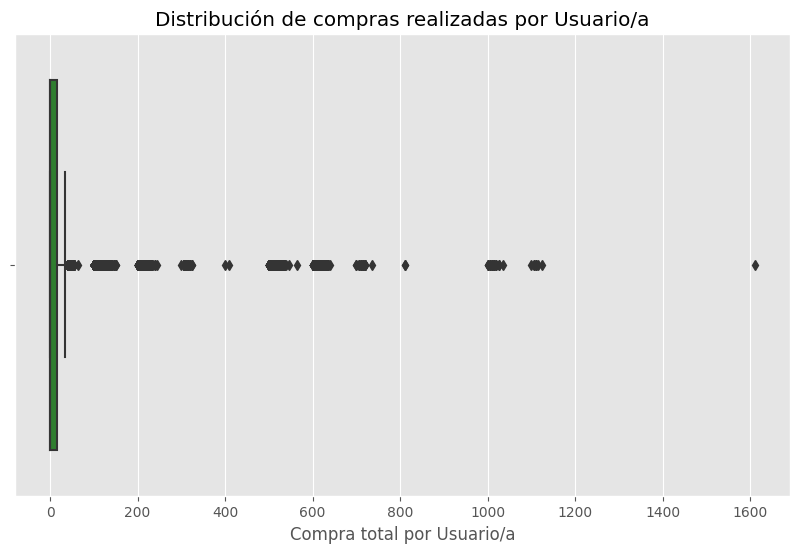

In [56]:
# crear boxplot para observar valores atipicos

with plt.style.context('ggplot'):

    # Crear el boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=user_buy, x='total_compras', color='forestgreen')

    plt.title('Distribución de compras realizadas por Usuario/a')
    plt.xlabel('Compra total por Usuario/a')
    
    plt.show()

In [57]:
print('La media es:', user_buy['total_compras'].mean())
print('La mediana es:', user_buy['total_compras'].median())
print('La moda es:', user_buy['total_compras'].mode())

La media es: 24.536597107473213
La mediana es: 0.0
La moda es: 0    0.0
dtype: float64


In [58]:
print(np.percentile(user_buy['total_compras'], [90,95,99,100]))

[  39.93  114.97  514.97 1609.94]


<span style="color:purple; font-weight:bold; font-size: 18px">
Al observar los graficos donde se muestra la distribución de los datos con respecto a las compras realizadas por usuario, se aprecia que existen muchos valores atípicos y algo inusial es que existen muchos usuarios que no realizaron compras, recordando al inicio del pre-procesamiento de datos se encontro un total de 363,447 los cuales se ven reflejados en la distribución, sin embargo tambien existen valores atipicos, por ejemplo la media de la compra de usuarios es de 24.53 usd, mientras que al calcular los percentiles se encontro que el 10% de los usuarios gasta  39.93 usd, el 5% gasta 114.97 usd y solo el 1% gasta 514.97 usd, y el gasto maximo encontrado en esta distribución es de 1609.94 usd. 
</span>

## Evaluar los resultados de la prueba A/B

### ¿Qué puedes decir sobre los resultados de la prueba A/B?

#### Unión de DF para realizar la prueba

In [59]:
# unir los df events y participants
events_participants = events.merge(participants, on='user_id', how='inner')

In [60]:
# unir el dl obtenido anteriormente con users
test = events_participants.merge(users, on='user_id', how='inner')

#### Calcular los dias transcurridos de la fecha de inscripcion hasta 14 dias despues

In [61]:
# agregar una columna con solo fechas 
test['event_fecha'] = test['event_dt'].dt.date

# convertir a datetime nueva columna
test['event_fecha'] = pd.to_datetime(test['event_fecha'])

In [62]:
# calcular los dias despues de la inscripcion 
test['days_signup'] = test['event_fecha'] - test['first_date']

In [63]:
# extraer el numero de dias de la columna sign up
test['days_signup'] = test['days_signup'].dt.days

In [64]:
# filtrar los datos dentro de los 14 dias de la inscripcion
filtro_dias = test[test['days_signup'] <= 14]

#### Calcular usuarios totales y unicos en cada grupo

In [65]:
# crear filtros para cada grupo 
filtered_a = filtro_dias.query('group == "A"')

filtered_b = filtro_dias.query('group == "B"')

In [66]:
# calcular usuarios totales y unicos para el grupo A
usuarios_totales_a = filtered_a['user_id'].shape[0]
print('El total de usuarios del grupo A es:',usuarios_totales_a)

exitos_a = filtered_a['user_id'].nunique()
print(f'El total de usuarios únicos (casos de exito) para el grupo A es de: {exitos_a}')

El total de usuarios del grupo A es: 57126
El total de usuarios únicos (casos de exito) para el grupo A es de: 7873


In [67]:
# calcular usuarios totales y unicos para el grupo B
usuarios_totales_b = filtered_b['user_id'].shape[0]
print('El total de usuarios del grupo B es:', usuarios_totales_b)

exitos_b = filtered_b['user_id'].nunique()
print(f'El total de usuarios únicos (casos de exito) para el grupo B es de: {exitos_b}')

El total de usuarios del grupo B es: 42664
El total de usuarios únicos (casos de exito) para el grupo B es de: 6204


#### Usuarios unicos por evento 

In [68]:
# encontrar los eventos por usuario unico del grupo A
usuarios_unicos_a = filtered_a.groupby('event_name').agg({'user_id': 'nunique'})
usuarios_unicos_a.sort_values(by='user_id', ascending = False, inplace = True)

print(usuarios_unicos_a)

              user_id
event_name           
login            7872
product_page     5207
purchase         2682
product_cart     2483


In [69]:
# encontrar los eventos por usuario unico del grupo B
usuarios_unicos_b = filtered_b.groupby('event_name').agg({'user_id': 'nunique'})
usuarios_unicos_b.sort_values(by='user_id', ascending = False, inplace = True)

print(usuarios_unicos_b)


              user_id
event_name           
login            6203
product_page     3985
product_cart     2037
purchase         2008


#### Calcula la tasa de conversion de cada uno de los usuarios/as en los dos grupos

In [70]:
# calculo de conversion para el grupo A
conversion_grupo_a = usuarios_unicos_a / usuarios_totales_a * 100
# ordenar los datos 
conversion_grupo_a = conversion_grupo_a.sort_values(by='user_id', ascending=False).reset_index()

# renombrar columnas 
conversion_grupo_a.columns = ['Stage', 'Proportion']

print(conversion_grupo_a.round(2))

          Stage  Proportion
0         login       13.78
1  product_page        9.11
2      purchase        4.69
3  product_cart        4.35


In [71]:
# Crear un nuevo índice para el grupo A
nuevo_orden = [0, 1, 3, 2]

# Reordenar el DataFrame
grupo_a_reordenado = conversion_grupo_a.reindex(nuevo_orden).round(2).reset_index(drop=True)

print(grupo_a_reordenado)

          Stage  Proportion
0         login       13.78
1  product_page        9.11
2  product_cart        4.35
3      purchase        4.69


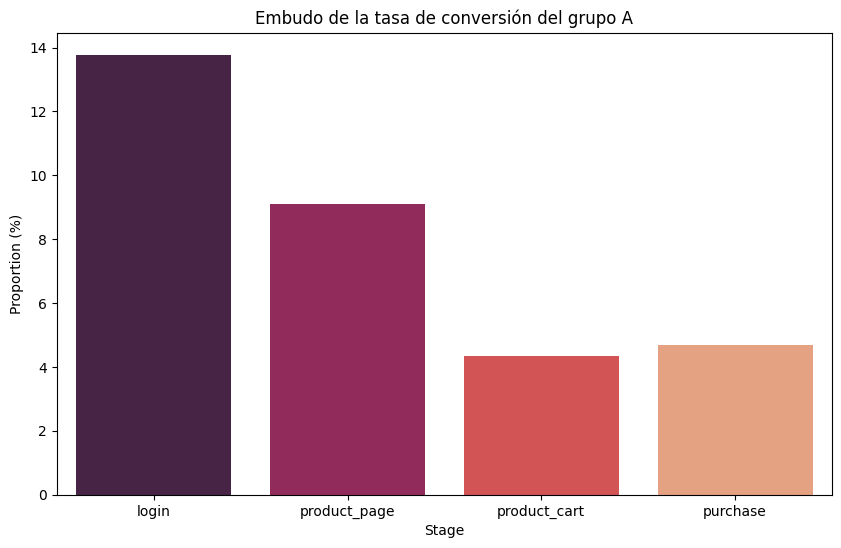

In [72]:
# mostrar embudo con la tasa de conversion para el grupo A
plt.figure(figsize=(10,6))

sns.barplot( 
    x='Stage',
    y ='Proportion',
    data = grupo_a_reordenado, palette = 'rocket' )

plt.title('Embudo de la tasa de conversión del grupo A')
plt.xlabel('Stage')
plt.ylabel('Proportion (%)')

plt.show()


In [73]:
# calculo de conversion para el grupo B
conversion_grupo_b = usuarios_unicos_b / usuarios_totales_b * 100

# ordenar los datos 
conversion_grupo_b = conversion_grupo_b.sort_values(by='user_id', ascending=False).round(2).reset_index()

# renombrar columnas 
conversion_grupo_b.columns = ['Stage', 'Proportion']

print(conversion_grupo_b)

          Stage  Proportion
0         login       14.54
1  product_page        9.34
2  product_cart        4.77
3      purchase        4.71


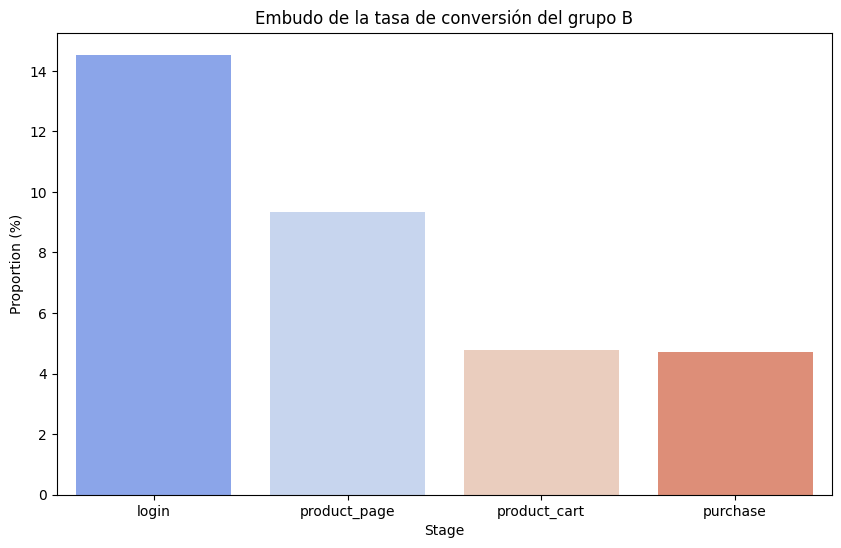

In [74]:
# mostrar embudo con la tasa de conversion para el grupo B
plt.figure(figsize=(10,6))

sns.barplot( 
    x='Stage',
    y ='Proportion',
    data = conversion_grupo_b, palette = 'coolwarm' )

plt.title('Embudo de la tasa de conversión del grupo B')
plt.xlabel('Stage')
plt.ylabel('Proportion (%)')

plt.show()

In [75]:
# unir los resultados en un DF nuevo
conversion_df = grupo_a_reordenado.merge(conversion_grupo_b, on='Stage')

conversion_df.columns=['Etapa','Grupo_A', 'Grupo_B']
conversion_df

,Etapa,Grupo_A,Grupo_B
0,login,13.78,14.54
1,product_page,9.11,9.34
2,product_cart,4.35,4.77
3,purchase,4.69,4.71


In [76]:
# Calcular el aumento
conversion_df['Aumento (%)'] = ((conversion_df['Grupo_B'] - conversion_df['Grupo_A']) / conversion_df['Grupo_A']) * 100

In [77]:
conversion_df

,Etapa,Grupo_A,Grupo_B,Aumento (%)
0,login,13.78,14.54,5.515239
1,product_page,9.11,9.34,2.524698
2,product_cart,4.35,4.77,9.655172
3,purchase,4.69,4.71,0.426439


<span style="color:purple; font-weight:bold; font-size: 18px">
Al calcular la tasa de conversion de las dos muestras se obtuvo un resultado no esperado ya que en las 4 etapas no se alcanza la meta establecida (solo product_cart se aproxima bastante obtuvo un 9.65%), la cual era conseguir un aumento de al menos un 10% en cada etapa del embundo, sin embargo, el numero de usuarios si fue alcanzando ya que en los dos grupos se tuvieron mas de 6000 participantes.
</span>

### Utiliza una prueba z para comprobar la diferencia estadística entre las proporciones

In [78]:
# nivel de significancia 
alpha = 0.05 

# crear arrays con datos de los grupos A y B
exitos = np.array([exitos_a, exitos_b])
pruebas = np.array([usuarios_totales_a, usuarios_totales_b])

# proporcion de exito en el primer grupo 
p1 = exitos[0] / pruebas[0]
# proporcion de exito en el segundo grupo 
p2 = exitos[1] / pruebas[1]

# proporcion de exito combinado
p_combinado = (exitos[0] + exitos[1]) / (pruebas[0] + pruebas[1])

# calcular diferencia 
diferencia = p1 - p2

In [79]:
# calcular las desviaciones estandar de la distribucion normal 
z_value = diferencia / mth.sqrt(p_combinado * (1 - p_combinado) * (1/pruebas[0] + 1/pruebas[1]))

# establecer la distribucion normal estandar (media 0, desviacion estandar 1)

distr = stats.norm(0,1)

In [80]:
# calcular p valor 
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value:', p_value)

if (p_value < alpha):
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")

p-value: 0.0006475564035339776
Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones


## Describe tus conclusiones con respecto a la etapa EDA y los resultados de la prueba A/B

<span style="color:purple; font-weight:bold; font-size: 18px">
Al realizar el EDA, se identificó que las muestras no estaban distribuidas equitativamente, ya que el grupo A contaba con un 56.6%, mientras que el grupo B representaba un 43.4%. Esto resultó en una diferencia del 13.2%, lo cual indica una mayor representación del grupo A, lo que podría influir en los resultados y dificultar una comparación directa.

Por otra parte, al analizar el embudo sin división de grupos, se encontró que solo una etapa (login) superaba el 10% de tasa de conversión; sin embargo, el resto de las etapas no alcanzaron este umbral. Al construir un embudo con las etapas esperadas, se obtuvo un resultado aún menos favorable: ninguna etapa logró superar el 10% de tasa de conversión. En concreto, se observó que solo el 56.82% de los usuarios realiza la acción de visitar la página del producto (product_page), apenas el 6.99% añade productos al carrito (product_cart), y solo el 0.03% de los usuarios iniciales completa una compra.

También se encontró que 441 usuarios estaban presentes en ambas muestras. Además, al analizar la distribución de los datos respecto al número de eventos por usuario, se identificaron numerosos valores atípicos. La media del total de eventos por usuario es de 7.2; al calcular los percentiles, se obtuvo que el 10% de los usuarios realiza 12 eventos, el 5% realiza 15 eventos y solo el 1% realiza 20 eventos. El número máximo de eventos registrados por usuario es 36.

Asimismo, se analizó la distribución de los datos respecto a las compras realizadas por usuario. En este caso, también se identificaron muchos valores atípicos. Algo notable es que un gran número de usuarios no realizó compras; durante el preprocesamiento, se encontró que había 363,447 usuarios en esta categoría, lo cual se refleja en la distribución. Sin embargo, entre los usuarios que realizaron compras, los valores son dispersos. La media del gasto por usuario es de 24.53 USD. En los percentiles, se encontró que el 10% de los usuarios gastó 39.93 USD, el 5% gastó 114.97 USD y solo el 1% gastó 514.97 USD. El gasto máximo registrado fue de 1,609.94 USD.

Al realizar la prueba A/B, se calculó la tasa de conversión para ambas muestras. Los resultados no fueron los esperados, ya que en las 4 etapas no se alcanzó la meta establecida (solo la etapa de product_cart se acerco obteniendo un 9.65%), que consistía en un aumento de al menos el 10% en cada etapa del embudo. Sin embargo, el número de usuarios participantes sí cumplió con los objetivos, ya que en ambos grupos hubo más de 6,000 participantes. Finalmente, al calcular la significancia estadística de la distribución de las muestras, con un nivel de significancia del 0.05, se obtuvo un valor p de 0.0006. Esto indica que se debe rechazar la hipótesis nula, lo que confirma que existe una diferencia significativa entre las muestras.
</span>